In [1]:
import sys
sys.path.append("..")

In [41]:
import ast
import time
import pandas as pd
import numpy as np
import csv

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import gensim
import torchtext
from torchtext import data
from torchtext import vocab
from gensim import corpora, models

import matplotlib.pyplot as plt
import seaborn as sns

from utils.db_client import DBClient
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Make DB Connection
db = DBClient(secrets_path='../configs/db_secrets.json')

I'm trying
Connected to political tweets DB


### Model definition and tuning

In [10]:
# Load data
examples = db.read("select tweet_text_clean, label from staging.train_twitter140 order by Random() limit 100000")

In [11]:
# Define Fields
txt_field = data.Field(sequential=True, 
                       include_lengths=True, 
                       use_vocab=True)
label_field = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                         unk_token=None)
train_val_fields = [
    ('SentimentText', txt_field), # process it as text
    ('Sentiment', label_field) # process it as label
]

# Convert text ecamples to Example datatype
examples = [data.Example.fromlist(((ast.literal_eval(example[0])), example[1]), train_val_fields) for example in examples]

# Create dataset
dataset = data.Dataset(examples, train_val_fields)

In [13]:
MAX_VOCAB_SIZE = 25000

# Make vocab for text and label fields
txt_field.build_vocab(dataset,
                      max_size = MAX_VOCAB_SIZE, 
                      vectors = vocab.Vectors('glove.twitter.27B.50d.txt', '../model/glove.twitter.27B/'))
label_field.build_vocab(dataset)

pretrained_embeddings = txt_field.vocab.vectors

# Make train/val/test splits
train_data, test_data, valid_data = dataset.split([0.7, 0.2, 0.1])

In [15]:
len(txt_field.vocab.itos)

25002

In [16]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 70000
Number of validation examples: 20000
Number of testing examples: 10000


In [130]:
len(train_data.examples)

70000

In [17]:
# Make data iterators
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
                                                          batch_sizes = (BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
                                                                        sort_key = lambda x: len(x.SentimentText),
                                                                        sort_within_batch=True,
                                                                        repeat = False)

In [18]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):#, optimizer, criterion):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.embedding_dim = embedding_dim
        self.pad_idx = pad_idx
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           #bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.optimizer = None #optimizer #optim.Adam(model.parameters())
        self.criterion = None #criterion #nn.BCEWithLogitsLoss()
        
    
    def set_pretrained_weights(self, pretrained_embeddings, txt_field):
        self.embedding.weight.data.copy_(pretrained_embeddings)

        UNK_IDX = txt_field.vocab.stoi[txt_field.unk_token]

        self.embedding.weight.data[UNK_IDX] = torch.zeros(self.embedding_dim)
        self.embedding.weight.data[self.pad_idx] = torch.zeros(self.embedding_dim)
    
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))
    
    def binary_accuracy(self, preds, y):
        """
        Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
        """

        #round predictions to the closest integer
        rounded_preds = torch.round(torch.sigmoid(preds))
        correct = (rounded_preds == y).float() #convert into float for division 
        acc = correct.sum() / len(correct)
        return acc
    
    def train_epoch(self, iterator):
        epoch_loss = 0
        epoch_acc = 0

        self.train()
        optimizer = self.optimizer
        for batch in iterator:
            if len(batch) == BATCH_SIZE:
            
                optimizer.zero_grad()

                text, text_lengths = batch.SentimentText
                predictions = self.forward(text, text_lengths).squeeze(1)
                loss = self.criterion(predictions, batch.Sentiment.float())

                acc = self.binary_accuracy(predictions, batch.Sentiment.float())

                loss.backward()

                optimizer.step()

                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)

    def evaluate(self, iterator):

        epoch_loss = 0
        epoch_acc = 0

        model.eval()

        with torch.no_grad():

            for batch in iterator:
                if len(batch) == BATCH_SIZE:

                    text, text_lengths = batch.SentimentText

                    predictions = self.forward(text, text_lengths).squeeze(1)

                    loss = self.criterion(predictions, batch.Sentiment.float())

                    acc = self.binary_accuracy(predictions, batch.Sentiment.float())

                    epoch_loss += loss.item()
                    epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
    def sentiment_political(self, iterator):
        
        sentiment_df = None

        with torch.no_grad():
            batch_no = 0

            for batch in iterator:
                if len(batch) == BATCH_SIZE:

                    text, text_lengths = batch.SentimentText

                    predictions = self.forward(text, text_lengths).squeeze(1)
                    
                    preds = torch.sigmoid(predictions)
                    
                    pred_arr = preds.numpy()
                    id_arr = batch.Id.numpy()
                    pred_class_arr = torch.round(preds).numpy()
                    
                    if batch_no == 0:
                        sentiment_df = pd.DataFrame({"tweet_id": id_arr, 
                                                     "prediction_raw": pred_arr, 
                                                     "prediction_class": pred_class_arr})
                    else:
                        sentiment_df = pd.concat([sentiment_df, pd.DataFrame({"tweet_id": id_arr, 
                                                     "prediction_raw": pred_arr, 
                                                     "prediction_class": pred_class_arr})])
                    batch_no += 1
            
        return sentiment_df
    
    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

In [133]:
def epoch_training(N_EPOCHS, model, train_iterator, valid_iterator):
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss, train_acc = model.train_epoch(train_iterator)
        valid_loss, valid_acc = model.evaluate(valid_iterator)

        end_time = time.time()

        epoch_mins, epoch_secs = model.epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut2-model.pt')

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
    return model

In [134]:
optimizers = ["Adam", "Adagrad"]
criterions = ["BCEWithLogitsLoss"] 
learning_rates = [0.01, 0.001]
epochs = [5, 25] 
weight_decay = [0, 0.01]

In [ ]:
INPUT_DIM = len(txt_field.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = txt_field.vocab.stoi[txt_field.pad_token]


best_model_tuple = None
best_accuracy = -1
for optimizer in optimizers:
    # Make a new model at the start
    model = LSTM(INPUT_DIM, 
                EMBEDDING_DIM, 
                HIDDEN_DIM, 
                OUTPUT_DIM, 
                N_LAYERS,
                DROPOUT, 
                PAD_IDX)
    model.set_pretrained_weights(pretrained_embeddings, txt_field)
    for learning_rate in learning_rates:
        for decay in weight_decay:
            # Set OPTIMIZER
            if optimizer == "Adam":
                model.optimizer = optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay = decay) 
            else: 
                model.optimizer = optim.Adagrad(params = model.parameters(), lr = learning_rate, weight_decay = decay)

            for criterion in criterions:
                # SET CRITERION
                if criterion == "BCEWithLogitsLoss":
                    model.criterion = nn.BCEWithLogitsLoss() 
                else: 
                    model.criterion = nn.NLLLoss()
                
                for epoch in epochs:
                    model_name = "-".join([optimizer, str(learning_rate), str(decay), str(criterion), str(epoch)])

                    print(f"working on model {model_name}")
                    trained_model = epoch_training(epoch, model, train_iterator, valid_iterator)
                    _, acc = trained_model.evaluate(valid_iterator)
                    
                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_model_tuple = (model_name, trained_model)


In [137]:
best_model_name = best_model_tuple[0]
best_model = best_model_tuple[1]

In [138]:
print(best_model_name)
best_model.evaluate(test_iterator)

Adam-0.001-0-BCEWithLogitsLoss-5


(0.4839125668546956, 0.7624402866242038)

In [139]:
run_no = "final"
torch.save(best_model.state_dict(), 'models_store/best_model_dict_{}_{}.pt'.format(best_model_name, run_no))
torch.save(best_model, 'models_store/best_model_{}_{}.pt'.format(best_model_name, run_no))


/Users/alenastern/.virtualenvs/aml/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Subject Analysis

In [19]:
# Load data
num_tweets = 100000
focus_topics = ['health', 'econ_jobs', 'immigration', 'taxes']
all_topics = ['civil_rights', 'courts', 'criminal_justice', 'drugs', 'econ_inequality', 'econ_jobs', 'education',
'environment', 'foreign_policy','governance', 'guns', 'health', 'immigration', 'pharma', 'puerto_rico', 'rural', 
'russia', 'shutdown', 'social_security', 'taxes', 'technology', 'women_rights']
topics_str = ', '.join(all_topics)
query_start = "select tweet_text_clean, tweet_id, tweet_text_raw, leadership, democrat, {} from staging.master".format(topics_str)

query = query_start
print(query)
db.conn.rollback()
examples_db = db.read(query)


select tweet_text_clean, tweet_id, tweet_text_raw, leadership, democrat, civil_rights, courts, criminal_justice, drugs, econ_inequality, econ_jobs, education, environment, foreign_policy, governance, guns, health, immigration, pharma, puerto_rico, rural, russia, shutdown, social_security, taxes, technology, women_rights from staging.master


In [20]:
examples_train = [(example[0], example[1]) for example in examples_db]

In [21]:
examples_train[0]

("['side', 'need', 'learn', 'firearm', 'current', 'process', 'weve', 'get', 'keep', 'firearm', 'secure', 'minor', 'people', 'restrain', 'order', 'shouldnt', 'weapon', 'need', 'improve', 'current', 'background', 'check', 'system']",
 '1000002839572353024')

In [22]:
# Define Fields
txt_field_eval = data.Field(sequential=True, 
                       include_lengths=True, 
                       use_vocab=True)

txt_field_eval.vocab = txt_field.vocab
id_field_eval = data.Field(sequential=False, 
                      use_vocab=False, 
                      pad_token=None, 
                      unk_token=None)

eval_val_fields = [
    ('SentimentText', txt_field_eval), # process it as text
    ('Id', id_field_eval) # process it as id
]


# Convert text examples to Example datatype
examples = [data.Example.fromlist(((ast.literal_eval(example[0])), example[1]), eval_val_fields) for example in examples_train]

# Create dataset
dataset = data.Dataset(examples, eval_val_fields)


In [23]:
txt_field_eval.vocab.vectors

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1259,  0.7006,  0.1237,  ...,  0.2219, -0.7194,  0.7646],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3252, -0.9471, -0.0113,  ..., -0.4641, -0.5404, -0.6724],
        [-0.1560, -0.3461, -0.6794,  ...,  0.2448, -0.2650, -0.4678]])

In [24]:
test_example = examples[0]
test_example.SentimentText

['side',
 'need',
 'learn',
 'firearm',
 'current',
 'process',
 'weve',
 'get',
 'keep',
 'firearm',
 'secure',
 'minor',
 'people',
 'restrain',
 'order',
 'shouldnt',
 'weapon',
 'need',
 'improve',
 'current',
 'background',
 'check',
 'system']

In [25]:
# Create Iterator
BATCH_SIZE = 64

eval_iterator = data.BucketIterator(dataset, 
                                           batch_size = BATCH_SIZE, 
                                           sort_key = lambda x: len(x.SentimentText),
                                           sort_within_batch=True,
                                           repeat = False)

In [26]:
# load best model
final_model = torch.load('models_store/best_model_Adam-0.001-0-BCEWithLogitsLoss-5_1.pt')
final_model.eval()

LSTM(
  (embedding): Embedding(25002, 50, padding_idx=1)
  (rnn): LSTM(50, 256, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
  (criterion): BCEWithLogitsLoss()
)

In [ ]:
# Calculate sentiment of each tweet
sentiment_df = final_model.sentiment_political(eval_iterator)


In [29]:
# Store political sentiment data
run_no = 1
sentiment_df.to_csv('models_store/political_sentiment_{}_{}.csv'.format("final_model_sentiment", run_no))

In [30]:
# calculate number of positive and negative tweets
sentiment_df.groupby('prediction_class').size()

prediction_class
0.0    82912
1.0    40224
dtype: int64

In [31]:
sentiment_df['tweet_id'] = pd.to_numeric(sentiment_df['tweet_id'])
sentiment_df.head()

,tweet_id,prediction_raw,prediction_class
0,748542118600245248,0.925690,1.0
1,53084818254204929,0.006733,0.0
2,200238810968244224,0.017363,0.0
3,881947748521566208,0.249771,0.0
4,1047192005581967362,0.006855,0.0


In [32]:
data_full = pd.DataFrame(examples_db, columns = ['tweet_text_clean', 'tweet_id', 
                                            'tweet_text_raw', 'leadership', 'democrat'] + all_topics )

In [33]:
data_full['tweet_id'] = pd.to_numeric(data_full['tweet_id'])
data_full.head()

,tweet_text_clean,tweet_id,tweet_text_raw,leadership,democrat,civil_rights,courts,criminal_justice,drugs,econ_inequality,...,immigration,pharma,puerto_rico,rural,russia,shutdown,social_security,taxes,technology,women_rights
0,"['side', 'need', 'learn', 'firearm', 'current'...",1000002839572353024,@amountainpass @MomsRising @redclaydems @georg...,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"['meeting', 'north', 'korea', 'cancel', 'north...",1000005238705844225,When the meeting with North Korea was cancelle...,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"['west', 'coast', 'attempt', 'literally', 'lim...",1000005833374265344,So the west coast has now attempted to literal...,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,"['say', 'everyone', 'play', 'game', 'regard', ...",1000006346144731136,.@realDonaldTrump saying “everyone plays games...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"['democrat', 'foreign', 'invader', 'godgiven',...",1000007055065911296,Democrats are foreign invaders on our God-give...,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Plotting Results

In [34]:
pol_data = data_full.merge(sentiment_df, on = 'tweet_id')
pol_data['negative'] = np.where((pol_data['prediction_class'] == 0), 1, 0)
pol_data['positive'] = np.where((pol_data['prediction_class'] == 1), 1, 0)
pol_data.head()

,tweet_text_clean,tweet_id,tweet_text_raw,leadership,democrat,civil_rights,courts,criminal_justice,drugs,econ_inequality,...,russia,shutdown,social_security,taxes,technology,women_rights,prediction_raw,prediction_class,negative,positive
0,"['side', 'need', 'learn', 'firearm', 'current'...",1000002839572353024,@amountainpass @MomsRising @redclaydems @georg...,True,True,False,False,False,False,False,...,False,False,False,False,False,False,0.925292,1.0,0,1
1,"['meeting', 'north', 'korea', 'cancel', 'north...",1000005238705844225,When the meeting with North Korea was cancelle...,True,False,False,False,False,False,False,...,False,False,False,False,False,False,0.049373,0.0,1,0
2,"['west', 'coast', 'attempt', 'literally', 'lim...",1000005833374265344,So the west coast has now attempted to literal...,False,True,False,False,False,False,False,...,False,False,False,False,False,False,0.129591,0.0,1,0
3,"['say', 'everyone', 'play', 'game', 'regard', ...",1000006346144731136,.@realDonaldTrump saying “everyone plays games...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.983489,1.0,0,1
4,"['democrat', 'foreign', 'invader', 'godgiven',...",1000007055065911296,Democrats are foreign invaders on our God-give...,False,True,False,False,False,False,False,...,False,False,False,False,False,False,0.011285,0.0,1,0


In [35]:
pol_data.to_csv('pol_data_all.csv')

In [36]:
choices = ['dem-lead', 'dem-base', 'rep-lead', 'rep-base']
palette = {"dem-base": "#a8b2ff","dem-lead": "#0015bc", "rep-base": "#ff9d9d", "rep-lead": "#ff0000", "": "gray"}


In [37]:
def results_for_plotting(df):
    # create group variable and reshape data for plotting
    df['group'] = np.where((df['democrat']==True) & (df['leadership']==True), 'dem-lead', 
        np.where((df['democrat']==True) & (df['leadership']==False), 'dem-base',
        np.where((df['democrat']==False) & (df['leadership']==True), 'rep-lead', 
        np.where((df['democrat']==False) & (df['leadership']==False), 'rep-base', ""))))

    plotting = pd.melt(df[df['group'] != ""], id_vars = ['democrat', 'leadership', 'group', 'tweet_id', 'tweet_text_raw', 'tweet_text_clean', 'prediction_class', 'prediction_raw'])

    return plotting
    
    

In [38]:
def plot(plotting, palette, topic, neg_pos_only = True):
    # create bar plot of sentiment by group
    if neg_pos_only:
        data = plotting[plotting['variable'].isin(['negative', 'positive'])]
    else:
        data = plotting
    plt.figure(figsize = (6, 3.5))
    sns_plot = sns.barplot(x='variable', y='value', hue='group', data=data, palette=palette)
    sns_plot.figure.savefig("plots/{}.png".format(topic))

/Users/alenastern/.virtualenvs/aml/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/alenastern/.virtualenvs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/alenastern/.virtualenvs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

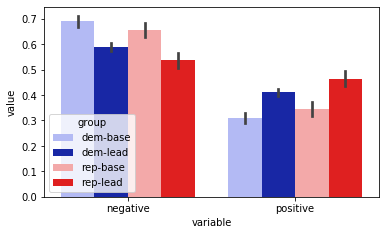

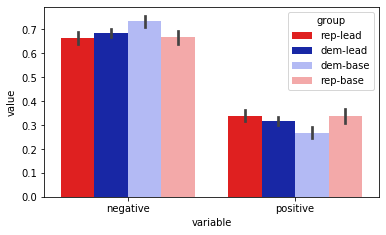

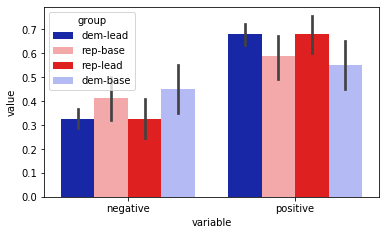

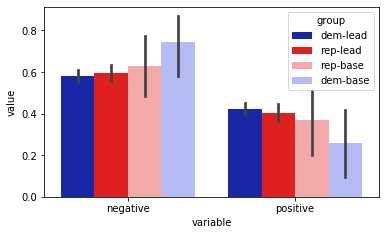

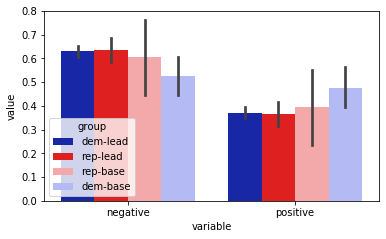

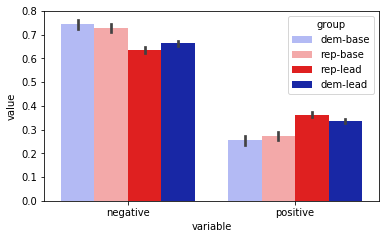

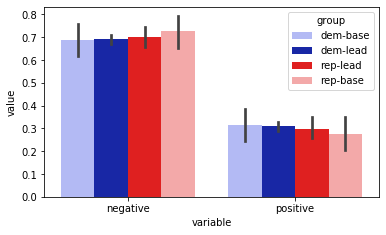

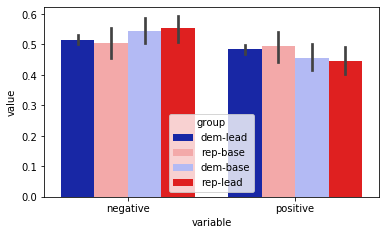

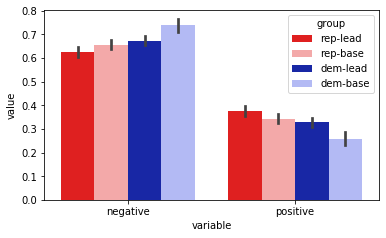

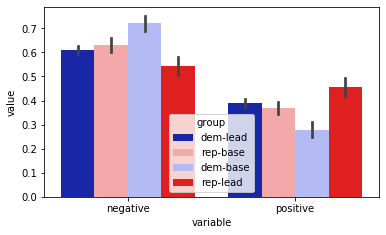

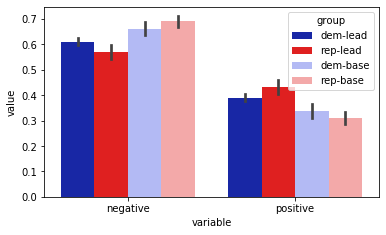

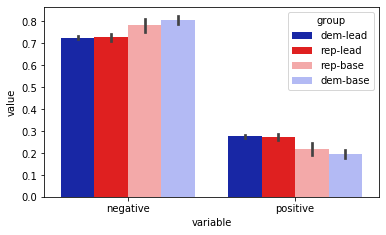

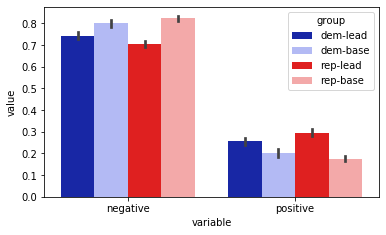

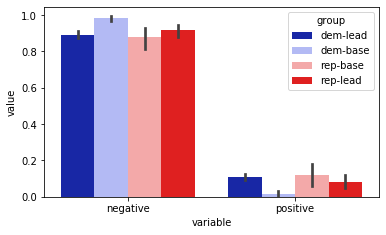

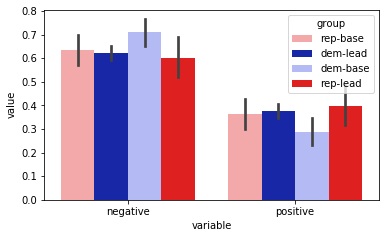

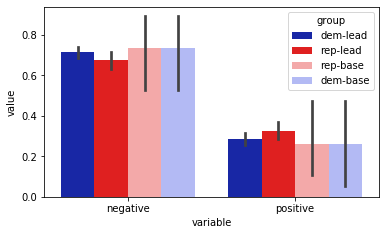

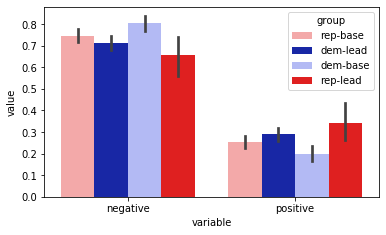

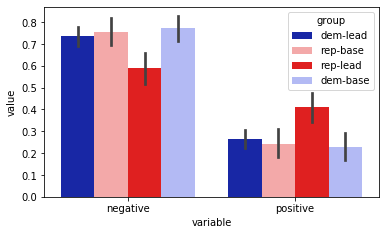

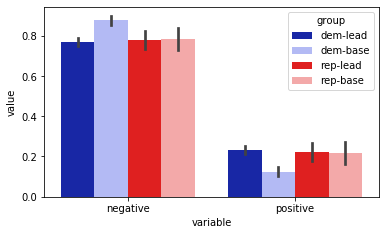

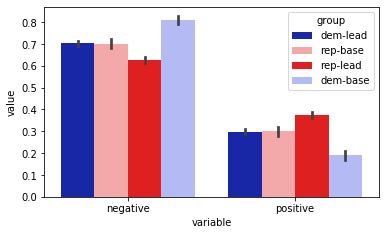

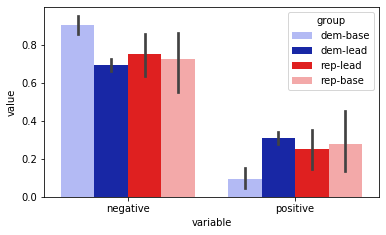

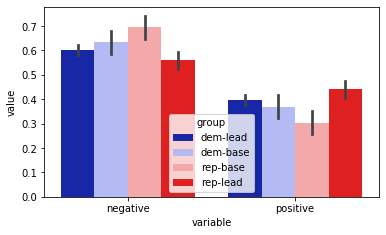

In [40]:
# create plots for all topics 
for topic in all_topics:
    topic_data = pol_data[pol_data[topic] == True]
    topic_data.drop(all_topics, axis=1, inplace=True)
    topic_data_plot = results_for_plotting(topic_data)
    plot(topic_data_plot, palette, topic)
    

### Word Counts

In [122]:
def word_counts(word_counts, num_words, word_dict):
    # create word counts for printing
    wc = []
    for tup in word_counts[0:num_words]:
        wc.append((word_dict[tup[0]], tup[1]))
    return wc

def print_word_counts(word_counts, num_words, word_dict):
    # print wordcounts for viewing
    for tup in word_counts[0:num_words]:
        print(f"{word_dict[tup[0]]}, {tup[1]} times")

def get_word_counts(bow_corpus):
    # get word counts for corpus
    counts = {}
    for bow in bow_corpus:
        for word in bow:
            if word[0] not in counts.keys():
                counts[word[0]] = 0
            counts[word[0]] += word[1]
    return [(k, counts[k]) for k in sorted(counts, key=counts.get, reverse=True)]

def get_idf(bow_corpus):
    # calculate IDF for corpus
    doc_counts = {}
    idf = {}
    for bow in bow_corpus:
        for word in bow:
            if word[0] not in doc_counts:
                doc_counts[word[0]] = 0
            doc_counts[word[0]] += 1
    for key, value in doc_counts.items():
        idf[key] = 1/value
    
    return idf 
            

In [80]:
# create group variable to calculate summary statistics
pol_data['tweet_text_clean'] = pol_data['tweet_text_clean'].apply(lambda x: ast.literal_eval(x))
df = pol_data
df['group'] = np.where((df['democrat']==True) & (df['leadership']==True), 'dem-lead', 
     np.where((df['democrat']==True) & (df['leadership']==False), 'dem-base',
     np.where((df['democrat']==False) & (df['leadership']==True), 'rep-lead', 
    np.where((df['democrat']==False) & (df['leadership']==False), 'rep-base', ""))))

In [110]:
# Calculate summary stats by group, group = "" is third party tweets
df['prediction_class'] = pd.to_numeric(df['prediction_class'])
df[['group', 'prediction_class']].groupby(['group']).mean()

,prediction_class
group,
,0.358358
dem-base,0.258022
dem-lead,0.339750
rep-base,0.288852
rep-lead,0.358325


In [123]:
# calculate IDF for vocabulary
word_dict = corpora.Dictionary(pol_data['tweet_text_clean'])
bow_corpus = [word_dict.doc2bow(doc) for  doc in pol_data['tweet_text_clean']]
idf = get_idf(bow_corpus)

In [128]:
# Calculate top TF-IDF words by topic-group
with open('tf_idf_topic_group.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Topic', 'Group', 'Class', 'Word', 'Count'])
    for topic in all_topics:
        #wd[topic] = {}
        for group in ['dem-lead', 'dem-base', 'rep-lead', 'rep-base']:
            for pred_class in [0, 1]:
                topic_group_data = df[(df[topic] == True) & (df['group'] == group) 
                                      & (df['prediction_class'] == pred_class)]
                word_dict = corpora.Dictionary(topic_group_data['tweet_text_clean'])
                bow_corpus = [word_dict.doc2bow(doc) for  doc in topic_group_data['tweet_text_clean']]
                wc = get_word_counts(bow_corpus)
                tf_idf = {}
                for tup in wc:
                    tf_idf[tup[0]] = tup[1] *idf[tup[0]]
                tf_idf_sort = [(k, tf_idf[k]) for k in sorted(tf_idf, key=tf_idf.get, reverse=True)]
                for tfidf_tup in tf_idf_sort[0:10]:
                    writer.writerow([topic, group, pred_class, word_dict[tfidf_tup[0]], tfidf_tup[1]])
            

In [261]:
# Calculate top frequency words by group
with open('top_words_topic_group.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Topic', 'Group', 'Class', 'Word', 'Count'])
    for topic in topics:
        #wd[topic] = {}
        for group in ['dem-lead', 'dem-base', 'rep-lead', 'rep-base']:
            for pred_class in [0, 1]:
                topic_group_data = df[(df[topic] == True) & (df['group'] == group) 
                                      & (df['prediction_class'] == pred_class)]
                topic_group_data['tweet_text_clean'] = topic_group_data['tweet_text_clean'].apply(lambda x: ast.literal_eval(x))
                word_dict = corpora.Dictionary(topic_group_data['tweet_text_clean'])
                bow_corpus = [word_dict.doc2bow(doc) for  doc in topic_group_data['tweet_text_clean']]
                wc = get_word_counts(bow_corpus)
                #wd[topic][group] = word_counts(wc, 10, word_dict)
                for tup in wc[0:10]:
                    writer.writerow([topic, group, pred_class, word_dict[tup[0]], tup[1]])

/Users/alenastern/.virtualenvs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [124]:
# Calculate summary statistics by topic-group
with open('sum_stat_group.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Topic', 'Group','Mean_Class','Std'])
    for topic in all_topics:
        for group in ['dem-lead', 'dem-base', 'rep-lead', 'rep-base']:
            topic_group_data = df[(df[topic] == True) & (df['group'] == group)]
            mean_class = topic_group_data['prediction_class'].mean()
            std = topic_group_data['prediction_raw'].std(axis=0)
            writer.writerow([topic, group, mean_class, std])

In [93]:
# calculate summary statistics 
sum_stat = pd.read_csv('sum_stat_group.csv')

In [94]:
sum_stat.head()

,Topic,Group,Mean_Class,Std
0,civil_rights,dem-lead,0.411296,0.383365
1,civil_rights,dem-base,0.309549,0.341997
2,civil_rights,rep-lead,0.464189,0.375719
3,civil_rights,rep-base,0.343348,0.357537
4,courts,dem-lead,0.315536,0.357186


In [96]:
# reformat summary statistics for paper
sum_stat = sum_stat.pivot(index='Topic', columns='Group', values=['Mean_Class', 'Std'])

In [99]:
sum_stat.to_csv('sum_stat_group_paper.csv')